In [107]:
import tensorflow as tf
import torch
import numpy as np
import pandas as pd
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [3]:
from ctgan.transformer import DataTransformer
from ctgan.sampler import Sampler
from ctgan.conditional import ConditionalGenerator

In [4]:
from ctgan_torch.synthesizer import CTGANSynthesizer

In [5]:
DEMO_URL = 'http://ctgan-data.s3.amazonaws.com/census.csv.gz'
train_data = pd.read_csv(DEMO_URL, compression='gzip')
discrete_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
]

In [6]:
transformer = DataTransformer()
transformer.fit(train_data, discrete_columns)
train_data = transformer.transform(train_data)

/home/pbm/.local/share/virtualenvs/ctgan-tf-9J9-GGaM/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/pbm/.local/share/virtualenvs/ctgan-tf-9J9-GGaM/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/pbm/.local/share/virtualenvs/ctgan-tf-9J9-GGaM/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/pbm/.local/share/virtualenvs/ctgan-tf-9J9-GGaM/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: In

In [7]:
data_sampler = Sampler(train_data, transformer.output_info)
data_dim = transformer.output_dimensions
cond_generator = ConditionalGenerator(
    train_data, transformer.output_info, True)

In [8]:
def w_bounded_initializer(fan_in):
    bound = math.sqrt(1 / fan_in)
    return tf.random_uniform_initializer(minval=-bound, maxval=bound)

In [9]:
class NewResidualLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(NewResidualLayer, self).__init__()
        self.num_outputs = num_outputs
        self.fc = None
        self.bn = None
        self.relu = None

    def build(self, input_shape):
        self.fc = tf.keras.layers.Dense(
            self.num_outputs, input_shape=input_shape,
            kernel_initializer=w_bounded_initializer(input_shape[1]), bias_initializer=w_bounded_initializer(input_shape[1]))
        self.bn = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9)
        self.relu = tf.keras.layers.ReLU()

    def call(self, inputs, **kwargs):
        outputs = self.fc(inputs)
        outputs = self.bn(outputs)
        outputs = self.relu(outputs)
        return tf.concat([outputs, inputs], axis=1)

In [10]:
from ctgan.layers import *
def build_generator(gen_dims, embedding_dim, data_dim):
    dim = embedding_dim
    model = inputs = tf.keras.Input(shape=(dim,))

    for layer_dim in list(gen_dims):
        model = NewResidualLayer(layer_dim)(model)
        dim += layer_dim

    outputs = tf.keras.layers.Dense(
        data_dim, kernel_initializer=w_bounded_initializer(dim),
        bias_initializer=w_bounded_initializer(dim))(model)
    #outputs = GenActLayer(
    #    data_dim, self.transformer.output_info_tensor(), self.tau)(model)
    return tf.keras.Model(inputs, outputs, name='Generator')

In [11]:
def build_critic(dis_dims, input_dim):
    pac_dim = input_dim * 10
    dim = pac_dim

    model = inputs = tf.keras.Input(shape=(input_dim,))
    model = tf.reshape(model, [-1, pac_dim])
    for layer_dim in list(dis_dims):
        model = tf.keras.layers.Dense(
            layer_dim, input_shape=(dim,), kernel_initializer=w_bounded_initializer(dim),
            bias_initializer=w_bounded_initializer(dim))(model)
        model = tf.keras.layers.LeakyReLU(0.2)(model)
        #model = tf.keras.layers.Dropout(0.5)(model)
        dim = layer_dim

    outputs = tf.keras.layers.Dense(
        1, input_shape=(dim,), kernel_initializer=w_bounded_initializer(dim),
        bias_initializer=w_bounded_initializer(dim))(model)
    return tf.keras.Model(inputs, outputs, name='Critic')

In [12]:
128 + cond_generator.n_opt

232

In [13]:
l2scale = 1e-6

In [149]:
generator = build_generator(
    (256,256), 128 + cond_generator.n_opt, data_dim)
critic = build_critic((256,256), data_dim + cond_generator.n_opt)

In [15]:
g_opt = tf.keras.optimizers.Adam(
    learning_rate=2e-4, beta_1=0.5, beta_2=0.9, epsilon=1e-08, decay=l2scale)
c_opt = tf.keras.optimizers.Adam(
    learning_rate=2e-4, beta_1=0.5, beta_2=0.9, epsilon=1e-08)

In [17]:
class Discriminator(torch.nn.Module):

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):

        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates, inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        gradient_penalty = ((
            gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        ) ** 2).mean() * lambda_

        return gradient_penalty

    def __init__(self, input_dim, dis_dims, pack=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pack
        self.pack = pack
        self.packdim = dim
        seq = []
        for item in list(dis_dims):
            seq += [torch.nn.Linear(dim, item), torch.nn.LeakyReLU(0.2)]
            #seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [torch.nn.Linear(dim, 1)]
        self.seq = torch.nn.Sequential(*seq)

    def forward(self, input):
        assert input.size()[0] % self.pack == 0
        return self.seq(input.view(-1, self.packdim))

In [153]:
from ctgan_torch.models import Generator
t_gen = Generator(
    128 + cond_generator.n_opt,
    (256,256),
    data_dim
)

t_critic = Discriminator(
    data_dim + cond_generator.n_opt,
    (256,256)
)

In [19]:
optimizerG = torch.optim.Adam(
    t_gen.parameters(), lr=2e-4, betas=(0.5, 0.9),
    weight_decay=l2scale
)
optimizerD = torch.optim.Adam(t_critic.parameters(), lr=2e-4, betas=(0.5, 0.9))

In [20]:
batch_size = 500
embedding_dim = z_dim = 128
mean = torch.zeros(batch_size, embedding_dim)
std = mean + 1

In [60]:
t_fakez = torch.normal(mean=mean, std=std)
tf_fakez = tf.random.normal([batch_size, z_dim])

fk = np.random.normal(size=(batch_size, z_dim)).astype(np.float32)
t_fakez = torch.from_numpy(fk)
tf_fakez = tf.convert_to_tensor(fk)

In [61]:
tf_fakez.shape

TensorShape([500, 128])

In [62]:
condvec = cond_generator.sample(batch_size)
if condvec is None:
    c1, m1, col, opt = None, None, None, None
    real = data_sampler.sample(batch_size, col, opt)
else:
    c1, m1, col, opt = condvec
    c1_tf = tf.convert_to_tensor(c1)
    m1_tf = tf.convert_to_tensor(m1)
    tf_fakez = tf.concat([tf_fakez, c1_tf], axis=1)
    
    c1_t = torch.from_numpy(c1)
    m1_t = torch.from_numpy(m1)
    t_fakez = torch.cat([t_fakez, c1_t], dim=1)

    perm = np.arange(batch_size)
    np.random.shuffle(perm)
    real = data_sampler.sample(batch_size, col[perm], opt[perm])
    tf_c2 = tf.gather(c1_tf, perm)
    t_c2 = c1_t[perm]

In [63]:
print(c1.shape)
print(c1_tf.shape)
print(c1_t.shape)
print(perm.shape)
print(tf_c2.shape)
print(t_c2.shape)

(500, 104)
(500, 104)
torch.Size([500, 104])
(500,)
(500, 104)
torch.Size([500, 104])


In [64]:
t_c2[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [65]:
t_c2[0][58]

tensor(0.)

In [385]:
tf.argmax(tf_c2, axis=1)

<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([ 81,  57,  20,  59,  59,  29, 103,   4,  30,  74,  58,  30, 103,
        31,   1, 103,  56,  67,  18,  51,  58,  79,   2,  57,   7,  57,
         2,  35,  50,  43,  31,   9,  59, 100,  20,  27,  56,  90,  28,
        21, 102,  28,  14, 102,  51,  93,  42,  29,  11, 103,  29,  59,
        82,  53,  51,   7,  10,  48,  59,  53,  50,   2,   7,  42,  59,
         5,  70, 103,   9,  46, 102, 103, 103,  99,   6,  38,  52, 102,
        52,  59,  33,  20,  15,  48,  15,   4,  47,  37,  27,  59,  59,
        57,  27,  72,  52,  47, 102,  47,  59, 102,  20,  50,  31, 103,
         6,  65,  47,  10,  93,  93,  55,  47,  20,  31,  50,  56,  49,
        53,  19,  52,   7,  48,  49,  78,  27,  10,  49,  55,  57,  17,
        55,  87,  24, 102,  51, 102,  48,  16,   4,  68,  56,  25,  30,
        56,  59,  25,   7,  11,  54,  31,   1,  90,  32,  27,  44,  71,
        52,   6,  48,  19,  57,  58,   4,  90,  50,  43,   5,  18,  12,
        59,  20,  

In [386]:
torch.argmax(t_c2, axis=1)

tensor([ 81,  57,  20,  59,  59,  29, 103,   4,  30,  74,  58,  30, 103,  31,
          1, 103,  56,  67,  18,  51,  58,  79,   2,  57,   7,  57,   2,  35,
         50,  43,  31,   9,  59, 100,  20,  27,  56,  90,  28,  21, 102,  28,
         14, 102,  51,  93,  42,  29,  11, 103,  29,  59,  82,  53,  51,   7,
         10,  48,  59,  53,  50,   2,   7,  42,  59,   5,  70, 103,   9,  46,
        102, 103, 103,  99,   6,  38,  52, 102,  52,  59,  33,  20,  15,  48,
         15,   4,  47,  37,  27,  59,  59,  57,  27,  72,  52,  47, 102,  47,
         59, 102,  20,  50,  31, 103,   6,  65,  47,  10,  93,  93,  55,  47,
         20,  31,  50,  56,  49,  53,  19,  52,   7,  48,  49,  78,  27,  10,
         49,  55,  57,  17,  55,  87,  24, 102,  51, 102,  48,  16,   4,  68,
         56,  25,  30,  56,  59,  25,   7,  11,  54,  31,   1,  90,  32,  27,
         44,  71,  52,   6,  48,  19,  57,  58,   4,  90,  50,  43,   5,  18,
         12,  59,  20,  58,  42,  16,  28, 102,  27,  57,  57,  

In [387]:
tf_fakez.shape

TensorShape([500, 232])

In [388]:
# Copy weights
generator.layers[1]._layers[0]._trainable_weights[0].shape

TensorShape([232, 256])

In [389]:
generator.layers[1]._layers[0].get_weights()

[array([[-0.03764651,  0.05668204, -0.01505546, ...,  0.04008025,
         -0.06013812, -0.00704082],
        [ 0.01103196,  0.0118294 , -0.01675732, ..., -0.05035019,
         -0.02672653,  0.03088796],
        [ 0.0390011 ,  0.05354697, -0.0017835 , ...,  0.05462016,
         -0.04271987, -0.02828104],
        ...,
        [ 0.05685727,  0.00479729, -0.01797788, ...,  0.01030193,
          0.01723725, -0.01634925],
        [ 0.01067467, -0.04512588, -0.00095568, ...,  0.03843996,
         -0.04763511,  0.05816013],
        [ 0.02865377, -0.01613199,  0.03471152, ..., -0.00883324,
          0.01592956,  0.03118502]], dtype=float32),
 array([ 4.76778150e-02, -1.90286450e-02, -5.00860028e-02,  2.25262493e-02,
        -1.21653304e-02,  5.29850870e-02,  5.28924242e-02, -3.04285958e-02,
         6.37199581e-02, -2.56376974e-02,  4.60203364e-02,  3.54235917e-02,
        -6.01835549e-03, -6.53408989e-02,  4.61541712e-02,  5.07733747e-02,
         3.77209485e-03,  5.27335778e-02, -1.55664235e

In [390]:
t_gen.seq[0].fc.weight

Parameter containing:
tensor([[ 0.0073,  0.0159, -0.0625,  ..., -0.0484,  0.0192, -0.0407],
        [ 0.0567, -0.0510,  0.0458,  ..., -0.0111,  0.0241,  0.0509],
        [-0.0613, -0.0066, -0.0222,  ..., -0.0422,  0.0240, -0.0471],
        ...,
        [-0.0598,  0.0419, -0.0210,  ..., -0.0634,  0.0532,  0.0451],
        [-0.0180,  0.0173, -0.0517,  ..., -0.0642, -0.0233,  0.0128],
        [ 0.0428, -0.0259,  0.0291,  ..., -0.0070,  0.0227, -0.0550]],
       requires_grad=True)

In [25]:
t_gen.seq[2].weight

Parameter containing:
tensor([[ 0.0276, -0.0188, -0.0242,  ..., -0.0074, -0.0106, -0.0201],
        [-0.0184, -0.0083,  0.0164,  ...,  0.0073, -0.0203,  0.0027],
        [-0.0326, -0.0228,  0.0361,  ...,  0.0227, -0.0081,  0.0250],
        ...,
        [-0.0074,  0.0019,  0.0148,  ...,  0.0067, -0.0137, -0.0037],
        [ 0.0345, -0.0214, -0.0298,  ...,  0.0033,  0.0312, -0.0021],
        [ 0.0163, -0.0061,  0.0145,  ...,  0.0071, -0.0068, -0.0286]],
       requires_grad=True)

In [26]:
generator.layers

In [119]:
generator.layers[1]._layers[0].set_weights([t_gen.seq[0].fc.weight.detach().numpy().T, t_gen.seq[0].fc.bias.detach().numpy()])
generator.layers[2]._layers[0].set_weights([t_gen.seq[1].fc.weight.detach().numpy().T, t_gen.seq[1].fc.bias.detach().numpy()])
generator.layers[3].set_weights([t_gen.seq[2].weight.detach().numpy().T, t_gen.seq[2].bias.detach().numpy()])

In [67]:
t_critic.seq

Sequential(
  (0): Linear(in_features=2610, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

In [68]:
critic.layers

In [120]:
critic.layers[2].set_weights([t_critic.seq[0].weight.detach().numpy().T, t_critic.seq[0].bias.detach().numpy()])
critic.layers[4].set_weights([t_critic.seq[2].weight.detach().numpy().T, t_critic.seq[2].bias.detach().numpy()])
critic.layers[6].set_weights([t_critic.seq[4].weight.detach().numpy().T, t_critic.seq[4].bias.detach().numpy()])

In [121]:
tf_fake = generator(tf_fakez, training=True)

In [71]:
t_fake = t_gen(t_fakez)

In [72]:
tf_fake

<tf.Tensor: shape=(500, 157), dtype=float32, numpy=
array([[-0.4187798 , -0.07809828, -0.45435774, ..., -0.26270318,
         0.26019856, -0.3573795 ],
       [-0.02661388, -0.33855942,  0.23149277, ...,  0.36736673,
        -0.1006417 ,  0.1564506 ],
       [-0.78372806, -0.16788357, -0.24720077, ..., -0.1206113 ,
         0.18430255,  0.42359757],
       ...,
       [-0.31727177, -0.39618668,  0.13995226, ...,  0.3078283 ,
        -0.07440005,  0.1218283 ],
       [-0.56266475, -0.16586661, -0.43288028, ..., -0.02165363,
         0.04636449, -0.24160317],
       [-0.8489312 , -0.02265953, -0.10653588, ..., -0.93605626,
         0.5015683 ,  0.5947409 ]], dtype=float32)>

In [73]:
t_fake

tensor([[-0.4188, -0.0781, -0.4544,  ..., -0.2627,  0.2602, -0.3574],
        [-0.0266, -0.3386,  0.2315,  ...,  0.3674, -0.1006,  0.1565],
        [-0.7837, -0.1679, -0.2472,  ..., -0.1206,  0.1843,  0.4236],
        ...,
        [-0.3173, -0.3962,  0.1400,  ...,  0.3078, -0.0744,  0.1218],
        [-0.5627, -0.1659, -0.4329,  ..., -0.0217,  0.0464, -0.2416],
        [-0.8489, -0.0227, -0.1065,  ..., -0.9361,  0.5016,  0.5947]],
       grad_fn=<AddmmBackward>)

In [74]:
tf.reduce_mean(tf_fake)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0033060154>

In [75]:
torch.mean(t_fake)

tensor(0.0033, grad_fn=<MeanBackward0>)

In [76]:
from ctgan.layers import _apply_activate
tf_fakeact = _apply_activate(tf_fake, transformer.output_info)

In [77]:
from torch.nn import functional
def torch_aa(data, transformer_info):
    data_t = []
    st = 0
    for item in transformer_info:
        if item[1] == 'tanh':
            ed = st + item[0]
            data_t.append(torch.tanh(data[:, st:ed]))
            st = ed
        elif item[1] == 'softmax':
            ed = st + item[0]
            data_t.append(functional.gumbel_softmax(data[:, st:ed], tau=0.2))
            st = ed
        else:
            assert 0

    return torch.cat(data_t, dim=1)
t_fakeact = torch_aa(t_fake, transformer.output_info)

In [78]:
tf_fakeact

<tf.Tensor: shape=(500, 157), dtype=float32, numpy=
array([[-3.9590195e-01,  6.7638725e-02,  6.1131288e-07, ...,
         1.6018544e-09,  1.0000000e+00,  7.0618520e-09],
       [-2.6607588e-02,  8.3749292e-08,  3.6598752e-07, ...,
         4.0921620e-13,  8.0534321e-01,  1.9465674e-01],
       [-6.5484136e-01,  3.6336452e-04,  9.9844724e-01, ...,
         5.5256817e-07,  6.7867586e-05,  9.9993217e-01],
       ...,
       [-3.0703795e-01,  2.2852166e-06,  1.6957204e-04, ...,
         4.8890553e-04,  8.7680554e-01,  1.2319446e-01],
       [-5.0995189e-01,  9.9998426e-01,  2.8544807e-07, ...,
         7.2024718e-06,  9.9992454e-01,  7.5414006e-05],
       [-6.9051075e-01,  3.9397492e-03,  2.6123038e-08, ...,
         8.8873848e-12,  2.5070903e-03,  9.9749291e-01]], dtype=float32)>

In [79]:
t_fakeact

tensor([[-3.9590e-01,  8.7536e-04,  2.0724e-08,  ...,  1.0803e-12,
          2.3546e-02,  9.7645e-01],
        [-2.6608e-02,  1.7889e-10,  1.8408e-06,  ...,  4.0740e-07,
          5.8393e-05,  9.9994e-01],
        [-6.5484e-01,  3.3387e-13,  8.7678e-12,  ...,  5.9147e-12,
          1.1216e-02,  9.8878e-01],
        ...,
        [-3.0704e-01,  1.6474e-12,  2.2179e-07,  ...,  4.1761e-09,
          9.8281e-01,  1.7194e-02],
        [-5.0995e-01,  1.8160e-04,  1.4614e-07,  ...,  2.2482e-09,
          9.9804e-01,  1.9620e-03],
        [-6.9051e-01,  1.0310e-04,  5.4244e-04,  ...,  6.0933e-12,
          9.8890e-01,  1.1101e-02]], grad_fn=<CatBackward>)

In [80]:
tf.reduce_mean(tf_fakeact)

<tf.Tensor: shape=(), dtype=float32, numpy=0.09556138>

In [81]:
torch.mean(t_fakeact)

tensor(0.0956, grad_fn=<MeanBackward0>)

In [406]:
t_gen

Generator(
  (seq): Sequential(
    (0): Residual(
      (fc): Linear(in_features=232, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Residual(
      (fc): Linear(in_features=488, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=744, out_features=157, bias=True)
  )
)

In [150]:
# Copy fakeact tensor
tf_fakeact = tf.convert_to_tensor(t_fakeact.detach().numpy())

In [83]:
tf_fakeact

<tf.Tensor: shape=(500, 157), dtype=float32, numpy=
array([[-3.9590198e-01,  8.7536272e-04,  2.0723824e-08, ...,
         1.0803212e-12,  2.3545912e-02,  9.7645414e-01],
       [-2.6607743e-02,  1.7889308e-10,  1.8407518e-06, ...,
         4.0739920e-07,  5.8392910e-05,  9.9994159e-01],
       [-6.5484118e-01,  3.3386775e-13,  8.7677730e-12, ...,
         5.9147361e-12,  1.1216190e-02,  9.8878378e-01],
       ...,
       [-3.0703804e-01,  1.6474165e-12,  2.2178554e-07, ...,
         4.1761439e-09,  9.8280615e-01,  1.7193921e-02],
       [-5.0995189e-01,  1.8159642e-04,  1.4613579e-07, ...,
         2.2481750e-09,  9.9803799e-01,  1.9620107e-03],
       [-6.9051075e-01,  1.0309785e-04,  5.4243894e-04, ...,
         6.0932674e-12,  9.8889869e-01,  1.1101375e-02]], dtype=float32)>

In [84]:
tf_real = tf.convert_to_tensor(real.astype('float32'))
t_real = torch.from_numpy(real.astype('float32'))

if c1 is not None:
    tf_fake_cat = tf.concat([tf_fakeact, c1_tf], axis=1)
    tf_real_cat = tf.concat([tf_real, tf_c2], axis=1)
    
    t_fake_cat = torch.cat([t_fakeact, c1_t], dim=1)
    t_real_cat = torch.cat([t_real, t_c2], dim=1)
else:
    tf_real_cat = tf_real
    tf_fake_cat = tf_fake
    
    t_real_cat = t_real
    t_fake_cat = t_fake

In [85]:
tf_y_fake = critic(tf_fake_cat, training=True)

In [154]:
t_y_fake = t_critic(t_fake_cat)

In [87]:
tf_y_fake

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[-0.01975694],
       [-0.03521845],
       [-0.02706474],
       [-0.03040547],
       [-0.01929938],
       [-0.00618731],
       [-0.04567712],
       [-0.01789412],
       [-0.00266659],
       [-0.03911324],
       [-0.00866736],
       [-0.00561859],
       [ 0.0058376 ],
       [-0.01995858],
       [-0.02778585],
       [-0.01739288],
       [-0.00269751],
       [-0.005191  ],
       [-0.01231703],
       [-0.00492575],
       [-0.02007423],
       [-0.00905174],
       [-0.00462009],
       [-0.01143287],
       [-0.00530553],
       [-0.03975953],
       [-0.02148912],
       [ 0.00226568],
       [ 0.01182339],
       [-0.00433119],
       [ 0.01670287],
       [-0.01726979],
       [-0.027688  ],
       [-0.03154159],
       [ 0.00285725],
       [-0.02357289],
       [-0.03529869],
       [-0.00375376],
       [-0.00500695],
       [-0.0702887 ],
       [-0.02352004],
       [-0.03421547],
       [-0.01750992],
     

In [88]:
t_y_fake

tensor([[-0.0198],
        [-0.0352],
        [-0.0271],
        [-0.0304],
        [-0.0193],
        [-0.0062],
        [-0.0457],
        [-0.0179],
        [-0.0027],
        [-0.0391],
        [-0.0087],
        [-0.0056],
        [ 0.0058],
        [-0.0200],
        [-0.0278],
        [-0.0174],
        [-0.0027],
        [-0.0052],
        [-0.0123],
        [-0.0049],
        [-0.0201],
        [-0.0091],
        [-0.0046],
        [-0.0114],
        [-0.0053],
        [-0.0398],
        [-0.0215],
        [ 0.0023],
        [ 0.0118],
        [-0.0043],
        [ 0.0167],
        [-0.0173],
        [-0.0277],
        [-0.0315],
        [ 0.0029],
        [-0.0236],
        [-0.0353],
        [-0.0038],
        [-0.0050],
        [-0.0703],
        [-0.0235],
        [-0.0342],
        [-0.0175],
        [-0.0068],
        [-0.0355],
        [-0.0247],
        [-0.0263],
        [-0.0082],
        [-0.0296],
        [-0.0184]], grad_fn=<AddmmBackward>)

In [89]:
tf.reduce_mean(tf_y_fake)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.017271483>

In [90]:
torch.mean(t_y_fake)

tensor(-0.0173, grad_fn=<MeanBackward0>)

In [91]:
tf_y_real = critic(tf_real_cat, training=True)

In [155]:
t_y_real = t_critic(t_real_cat)

In [93]:
tf.reduce_mean(tf_y_real)

<tf.Tensor: shape=(), dtype=float32, numpy=0.007804858>

In [94]:
torch.mean(t_y_real)

tensor(0.0078, grad_fn=<MeanBackward0>)

In [95]:
t_gp = t_critic.calc_gradient_penalty(t_real_cat, t_fake_cat)

In [96]:
t_gp

tensor(8.2349, grad_fn=<MulBackward0>)

In [156]:
t_loss_d = -(torch.mean(t_y_real) - torch.mean(t_y_fake))
t_loss_d

tensor(0.0145, grad_fn=<NegBackward>)

In [98]:
tf_loss_d = -(tf.reduce_mean(tf_y_real) - tf.reduce_mean(tf_y_fake))
tf_loss_d

<tf.Tensor: shape=(), dtype=float32, numpy=-0.02507634>

In [99]:
from functools import partial
def gradient_penalty(f, real, fake):
    pac = 10
    grad_penalty_lambda = 10
    """Calculates the gradient penalty loss for a batch of "averaged" samples.
    In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the
    loss function that penalizes the network if the gradient norm moves away from 1.
    However, it is impossible to evaluate this function at all points in the input
    space. The compromise used in the paper is to choose random points on the lines
    between real and generated samples, and check the gradients at these points. Note
    that it is the gradient w.r.t. the input averaged samples, not the weights of the
    discriminator, that we're penalizing!
    In order to evaluate the gradients, we must first run samples through the generator
    and evaluate the loss. Then we get the gradients of the discriminator w.r.t. the
    input averaged samples. The l2 norm and penalty can then be calculated for this
    gradient.
    """
    alpha = tf.random.uniform([real.shape[0] // pac, 1, 1], 0., 1.)
    alpha = tf.tile(alpha, tf.constant([1, pac, real.shape[1]], tf.int32))
    alpha = tf.reshape(alpha, [-1, real.shape[1]])

    interpolates = alpha * real + ((1 - alpha) * fake)
    with tf.GradientTape() as t:
        t.watch(interpolates)
        pred = f(interpolates)
    grad = t.gradient(pred, [interpolates])[0]
    grad = tf.reshape(grad, tf.constant([-1, pac * real.shape[1]], tf.int32))

    slopes = tf.math.reduce_euclidean_norm(grad, axis=1)
    gp = tf.reduce_mean((slopes - 1.) ** 2) * grad_penalty_lambda
    return gp, grad

In [100]:
tf_gp = gradient_penalty(partial(critic, training=True), tf_real_cat, tf_fake_cat)
tf_gp

(<tf.Tensor: shape=(), dtype=float32, numpy=8.223752>,
 <tf.Tensor: shape=(50, 2610), dtype=float32, numpy=
 array([[-0.00011831, -0.00010503, -0.00045025, ..., -0.00089978,
          0.00249894,  0.00085695],
        [ 0.00018913, -0.00010462,  0.00047823, ..., -0.00070234,
         -0.00074406,  0.00106605],
        [ 0.00093401,  0.00182756, -0.00192058, ..., -0.00076434,
         -0.00104219, -0.00083124],
        ...,
        [-0.0005071 ,  0.00011405,  0.00043326, ..., -0.00031921,
          0.00262569,  0.00088511],
        [ 0.00094843, -0.00020754, -0.00157178, ..., -0.00065871,
         -0.00173609, -0.00065214],
        [ 0.00186859, -0.00023233,  0.00011694, ..., -0.00219127,
         -0.00092699,  0.0004767 ]], dtype=float32)>)

In [151]:
with tf.GradientTape() as tape:
    tf_gp = gradient_penalty(partial(critic, training=True), tf_real_cat, tf_fake_cat)
    
grad_gp = tape.gradient(tf_gp, critic.trainable_variables)

In [152]:
grad_gp

[<tf.Tensor: shape=(2610, 256), dtype=float32, numpy=
 array([[-1.0777783 ,  0.27094018,  0.9440666 , ..., -0.23659445,
          0.2668177 ,  0.61972374],
        [-1.0920055 ,  0.2741965 ,  0.9558313 , ..., -0.23971407,
          0.26984993,  0.62760645],
        [-1.0808088 ,  0.2720686 ,  0.9471559 , ..., -0.2374901 ,
          0.2673103 ,  0.62190545],
        ...,
        [-1.0797341 ,  0.27165574,  0.9454136 , ..., -0.23714651,
          0.26714626,  0.62146664],
        [-1.0853784 ,  0.27275133,  0.9514272 , ..., -0.23838046,
          0.26849732,  0.6234146 ],
        [-1.0839667 ,  0.27244082,  0.9499051 , ..., -0.23819205,
          0.26804805,  0.62320656]], dtype=float32)>,
 <tf.Tensor: shape=(256,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.

In [354]:
optimizerD.zero_grad()
optimizerD.__dict__

{'defaults': {'lr': 0.0002,
  'betas': (0.5, 0.9),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False},
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([[ 0.0163,  0.0124, -0.0163,  ..., -0.0004,  0.0146, -0.0106],
            [-0.0192,  0.0188,  0.0155,  ...,  0.0120, -0.0132, -0.0184],
            [-0.0131,  0.0109, -0.0061,  ...,  0.0023,  0.0022,  0.0137],
            ...,
            [-0.0108, -0.0129, -0.0170,  ..., -0.0147,  0.0042, -0.0042],
            [ 0.0120, -0.0030, -0.0169,  ...,  0.0191,  0.0042,  0.0146],
            [ 0.0049,  0.0007,  0.0106,  ...,  0.0003,  0.0150, -0.0084]],
           requires_grad=True), Parameter containing:
    tensor([-1.3351e-02, -1.0941e-02, -6.7249e-03, -1.3250e-03,  1.1146e-02,
             1.8301e-02, -1.4587e-02,  1.1343e-02, -2.4589e-04,  4.6031e-03,
            -1.0602e-02, -1.2261e-02,  8.8981e-03, -4.9186e-03,  1.1596e-02,
             8.6489e-04, -4.8088e-03, -3.2151e-03, -1.3509e

In [101]:
t_gp.backward(retain_graph=True)
t_gp

tensor(8.2349, grad_fn=<MulBackward0>)

In [102]:
t_critic.seq[0].weight.grad

tensor([[ 8.1824e-04, -2.7391e-04, -6.2475e-04,  ..., -2.1064e-04,
          4.2082e-04, -3.5965e-04],
        [ 1.7934e-03,  5.3336e-04,  2.5052e-04,  ..., -2.9064e-04,
          8.8117e-04, -2.0011e-04],
        [-1.2459e-03, -3.8332e-05,  1.0386e-04,  ...,  6.1702e-04,
         -8.9989e-04,  4.9087e-04],
        ...,
        [ 4.1450e-03,  4.3000e-04, -7.2197e-04,  ..., -1.8750e-03,
          2.3605e-03, -1.4397e-03],
        [-4.0897e-04, -1.5384e-04, -3.0192e-05,  ...,  9.3842e-05,
         -3.5374e-04, -1.3230e-05],
        [ 1.2421e-03,  2.6988e-04,  2.4461e-04,  ..., -3.1488e-04,
          4.9745e-04, -4.5577e-04]])

In [103]:
t_loss_d.backward()

In [104]:
t_loss_d

tensor(-0.0251, grad_fn=<NegBackward>)

In [105]:
t_critic.seq[0].weight.grad

tensor([[ 8.8448e-04,  2.8330e-04, -6.6188e-05,  ..., -2.1064e-04,
          2.9921e-04, -9.0573e-05],
        [ 2.7839e-03,  1.4679e-04,  1.4376e-03,  ..., -2.9064e-04,
          1.1271e-03, -5.3652e-04],
        [-3.1084e-03,  4.0420e-04,  6.2632e-05,  ...,  6.1702e-04,
         -4.4518e-04,  9.5357e-04],
        ...,
        [ 7.6237e-03, -8.0289e-05,  9.4811e-04,  ..., -1.8750e-03,
          2.5338e-03, -2.6250e-03],
        [-7.6603e-04,  1.4471e-05, -2.2797e-04,  ...,  9.3842e-05,
         -3.1771e-04,  1.4563e-04],
        [ 2.2829e-03, -4.1431e-05,  3.8710e-04,  ..., -3.1488e-04,
          3.8208e-04, -1.2089e-03]])

In [358]:
critic.layers[2].get_weights()

[array([[ 0.0104399 ,  0.01184333,  0.01947265, ..., -0.0027608 ,
         -0.01557249, -0.01212248],
        [ 0.00224579,  0.00807676, -0.01378748, ..., -0.00601036,
          0.01693137,  0.01323721],
        [ 0.0020137 , -0.00083041, -0.00361929, ..., -0.00249561,
         -0.00936469,  0.010633  ],
        ...,
        [-0.01081521, -0.01476025,  0.0117516 , ...,  0.00693588,
          0.01374665,  0.01564172],
        [-0.00745518, -0.01488712,  0.0038322 , ...,  0.0155443 ,
         -0.00698683, -0.00584035],
        [-0.0155228 ,  0.01571267,  0.01004028, ..., -0.00628184,
          0.00725948,  0.01036368]], dtype=float32),
 array([ 1.66940410e-02,  2.23425217e-03, -7.43286964e-03, -1.47542916e-03,
         9.45699401e-03, -1.30710918e-02,  1.47559289e-02,  9.15290043e-03,
         7.99017027e-03, -1.58500820e-02,  8.09426419e-03,  1.32698175e-02,
        -1.37109384e-02, -5.47817815e-03, -1.46102719e-03,  3.40034813e-03,
        -5.75557258e-03,  6.31612726e-03,  4.94072959e

In [359]:
t_critic.seq[0].weight

Parameter containing:
tensor([[ 0.0163,  0.0124, -0.0163,  ..., -0.0004,  0.0146, -0.0106],
        [-0.0192,  0.0188,  0.0155,  ...,  0.0120, -0.0132, -0.0184],
        [-0.0131,  0.0109, -0.0061,  ...,  0.0023,  0.0022,  0.0137],
        ...,
        [-0.0108, -0.0129, -0.0170,  ..., -0.0147,  0.0042, -0.0042],
        [ 0.0120, -0.0030, -0.0169,  ...,  0.0191,  0.0042,  0.0146],
        [ 0.0049,  0.0007,  0.0106,  ...,  0.0003,  0.0150, -0.0084]],
       requires_grad=True)

In [360]:
t_critic.seq[0].weight.grad

tensor([[-1.5633e-03,  1.2914e-03, -7.1314e-04,  ..., -1.0134e-03,
         -3.5647e-04,  1.2298e-03],
        [-3.2595e-03,  3.8940e-03, -3.3937e-03,  ..., -1.9960e-03,
          4.3995e-03, -7.8326e-04],
        [ 4.7520e-03, -1.3873e-02,  2.0280e-03,  ...,  1.0689e-03,
         -1.8877e-03, -1.2008e-03],
        ...,
        [-2.9485e-03,  1.9002e-03, -3.4709e-04,  ...,  1.5540e-03,
         -7.1688e-04, -1.8752e-04],
        [ 1.4912e-04,  4.3985e-04, -1.5630e-04,  ..., -8.4302e-04,
         -1.3910e-05,  1.6877e-04],
        [-3.4643e-03, -4.2893e-04, -1.9360e-03,  ...,  8.4137e-04,
          6.2718e-04, -6.1740e-04]])

In [126]:
tf_fake_cat

<tf.Tensor: shape=(500, 261), dtype=float32, numpy=
array([[-3.9590198e-01,  8.7536272e-04,  2.0723824e-08, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.6607743e-02,  1.7889308e-10,  1.8407518e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-6.5484118e-01,  3.3386775e-13,  8.7677730e-12, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-3.0703804e-01,  1.6474165e-12,  2.2178554e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.0995189e-01,  1.8159642e-04,  1.4613579e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-6.9051075e-01,  1.0309785e-04,  5.4243894e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)>

In [123]:
tf_real_cat

<tf.Tensor: shape=(500, 261), dtype=float32, numpy=
array([[-0.2056393 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.64818996,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07623339,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.35082757,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22385882,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23402095,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [124]:
t_real_cat

tensor([[-0.2056,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6482,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0762,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.3508,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2239,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2340,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [127]:
with tf.GradientTape(persistent=True) as t:
    tf_y_fake = critic(tf_fake_cat, training=True)
    tf_y_real = critic(tf_real_cat, training=True)
    tf_loss_d = -(tf.reduce_mean(tf_y_real) - tf.reduce_mean(tf_y_fake))
    tf_gp, gp = gradient_penalty(partial(critic, training=True), tf_real_cat, tf_fake_cat)
    cost = tf_loss_d + tf_gp

In [128]:
tf_gp

<tf.Tensor: shape=(), dtype=float32, numpy=8.229103>

In [129]:
tf_loss_d

<tf.Tensor: shape=(), dtype=float32, numpy=-0.02507634>

In [130]:
cost

<tf.Tensor: shape=(), dtype=float32, numpy=8.204027>

In [417]:
cost = tf.convert_to_tensor(t_loss_d.detach().numpy() + t_gp.detach().numpy())

In [418]:
cost

<tf.Tensor: shape=(), dtype=float32, numpy=6.3227425>

In [144]:
grad = t.gradient(tf_gp, critic.trainable_variables)

In [145]:
grad

[<tf.Tensor: shape=(2610, 256), dtype=float32, numpy=
 array([[ 6.3575263e-04,  2.0147478e-03, -1.1984204e-03, ...,
          4.4410476e-03, -5.8962184e-04,  1.3334041e-03],
        [ 4.2708783e-04,  9.7449974e-04, -7.2358892e-04, ...,
          2.6475592e-03, -4.3553504e-04,  7.2811614e-04],
        [-3.2870044e-04,  5.1470415e-05,  4.0892590e-04, ...,
         -6.2779197e-04, -4.8983213e-05,  3.5122811e-04],
        ...,
        [-4.4708057e-05, -3.2372115e-04,  5.9729093e-04, ...,
         -9.5574453e-04,  2.0837701e-04, -1.6527405e-04],
        [ 2.5272137e-04,  1.3362339e-03, -8.5645024e-04, ...,
          2.1318488e-03, -2.6881779e-04,  3.8752810e-04],
        [-1.5489446e-05, -4.1213314e-04,  3.3813462e-04, ...,
         -1.3265157e-03,  3.7063481e-04, -4.4316257e-04]], dtype=float32)>,
 <tf.Tensor: shape=(256,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [142]:
grad = t.gradient(tf_loss_d, critic.trainable_variables)

In [143]:
grad

[<tf.Tensor: shape=(2610, 256), dtype=float32, numpy=
 array([[ 6.6245382e-05,  9.9050801e-04, -1.8625397e-03, ...,
          3.4787126e-03, -3.5706168e-04,  1.0407791e-03],
        [ 5.5721164e-04, -3.8657762e-04,  4.4253503e-04, ...,
         -5.1029085e-04,  1.6830795e-04, -3.1131302e-04],
        [ 5.5856252e-04,  1.1870896e-03, -4.1227497e-05, ...,
          1.6700830e-03, -1.9777345e-04,  1.4248429e-04],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-1.2161527e-04,  2.4590408e-04,  4.5470815e-04, ...,
          1.7331837e-04,  3.6030549e-05, -1.1536951e-04],
        [ 2.6907743e-04, -3.3640891e-04,  4.6269613e-04, ...,
         -1.1852864e-03,  1.5886135e-04, -7.5309415e-04]], dtype=float32)>,
 <tf.Tensor: shape=(256,), dtype=float32, numpy=
 array([ 3.24308267e-03, -2.52615754e-03,  2.97091668e-03, -6.04660250e-04,
         2.55767722e-04, -3.57699068e-03,  1.08886231e-03, -1.07133808

In [133]:
t_critic.seq[0].weight.grad

tensor([[ 8.8448e-04,  2.8330e-04, -6.6188e-05,  ..., -2.1064e-04,
          2.9921e-04, -9.0573e-05],
        [ 2.7839e-03,  1.4679e-04,  1.4376e-03,  ..., -2.9064e-04,
          1.1271e-03, -5.3652e-04],
        [-3.1084e-03,  4.0420e-04,  6.2632e-05,  ...,  6.1702e-04,
         -4.4518e-04,  9.5357e-04],
        ...,
        [ 7.6237e-03, -8.0289e-05,  9.4811e-04,  ..., -1.8750e-03,
          2.5338e-03, -2.6250e-03],
        [-7.6603e-04,  1.4471e-05, -2.2797e-04,  ...,  9.3842e-05,
         -3.1771e-04,  1.4563e-04],
        [ 2.2829e-03, -4.1431e-05,  3.8710e-04,  ..., -3.1488e-04,
          3.8208e-04, -1.2089e-03]])

In [427]:
optimizerD.step()

In [428]:
t_critic.seq[0].weight

Parameter containing:
tensor([[-0.0084,  0.0095, -0.0161,  ...,  0.0129, -0.0152,  0.0041],
        [-0.0060, -0.0086,  0.0018,  ...,  0.0002,  0.0185,  0.0077],
        [-0.0010,  0.0117,  0.0085,  ..., -0.0044, -0.0011, -0.0188],
        ...,
        [-0.0051,  0.0191, -0.0106,  ...,  0.0106, -0.0060, -0.0164],
        [-0.0182,  0.0036, -0.0121,  ..., -0.0116, -0.0085,  0.0102],
        [ 0.0094, -0.0041,  0.0078,  ...,  0.0011, -0.0084,  0.0101]],
       requires_grad=True)

In [369]:
c_opt.apply_gradients(zip(grad, critic.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [370]:
critic.layers[2].get_weights()

[array([[ 0.01023991,  0.01164333,  0.01967265, ..., -0.0029608 ,
         -0.01577247, -0.01232242],
        [ 0.0020458 ,  0.00827675, -0.01398748, ..., -0.00581037,
          0.01713137,  0.01343718],
        [ 0.0022137 , -0.0010304 , -0.00381926, ..., -0.00229566,
         -0.00956469,  0.01083299],
        ...,
        [-0.01061529, -0.01496025,  0.01195158, ...,  0.0071358 ,
          0.01354668,  0.01584167],
        [-0.00725519, -0.01508712,  0.00363221, ...,  0.0157443 ,
         -0.00718683, -0.00604033],
        [-0.01532289,  0.01551268,  0.01024026, ..., -0.00608184,
          0.0070595 ,  0.01016369]], dtype=float32),
 array([ 0.01689404,  0.00203425, -0.00763287, -0.00127543,  0.00965699,
        -0.0128711 ,  0.01495593,  0.0089529 ,  0.00779017, -0.01565008,
         0.00789427,  0.01306982, -0.01351094, -0.00567817, -0.00166103,
         0.00360035, -0.00595557,  0.00651611,  0.00474073, -0.00739698,
         0.01519718,  0.01776695, -0.01098582, -0.01950295,  0.001

In [373]:
a = 2e-4
e = 1e-08
b1 = 0.5
b2 = 0.9
m0 = 0
v0 = 0
t = 0

t = t+1

gt = 4.23174963e-04
mt = b1 * m0 + (1-b1)*gt
vt = b2 * v0 + (1-b2) * gt**2
mt_hat = mt / (1 - b1**t)
vt_hat = vt / (1 - b2**t)
teta_t_1 = 0.0104399
teta_t = teta_t_1 - a * mt_hat / (math.sqrt(vt_hat) + e)
teta_t

0.010239904726065846

# Weights analysis

In [42]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 232)]             0         
_________________________________________________________________
new_residual_layer (NewResid (None, 488)               60672     
_________________________________________________________________
new_residual_layer_1 (NewRes (None, 744)               126208    
_________________________________________________________________
dense_4 (Dense)              (None, 157)               116965    
Total params: 303,845
Trainable params: 302,821
Non-trainable params: 1,024
_________________________________________________________________


In [429]:
critic.summary()

Model: "Critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 261)]             0         
_________________________________________________________________
tf_op_layer_Reshape_11 (Tens [(None, 2610)]            0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               668416    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 256)               0    

In [430]:
t_critic

Discriminator(
  (seq): Sequential(
    (0): Linear(in_features=2610, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [230]:
t_critic.seq[2]

Dropout(p=0.5, inplace=False)

In [223]:
t_gen.seq[0].fc.__dict__

{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[ 0.0321, -0.0210, -0.0292,  ..., -0.0442, -0.0548, -0.0533],
                       [ 0.0163, -0.0244, -0.0453,  ..., -0.0620,  0.0426,  0.0186],
                       [-0.0309,  0.0498,  0.0440,  ...,  0.0140, -0.0274, -0.0631],
                       ...,
                       [-0.0633, -0.0458, -0.0442,  ...,  0.0272,  0.0087,  0.0544],
                       [-0.0562, -0.0516,  0.0057,  ..., -0.0579, -0.0136,  0.0151],
                       [-0.0354,  0.0062, -0.0506,  ..., -0.0583,  0.0075, -0.0525]],
                      requires_grad=True)), ('bias', Parameter containing:
               tensor([-0.0456,  0.0136, -0.0099, -0.0207,  0.0614,  0.0270, -0.0398,  0.0073,
                       -0.0231,  0.0609,  0.0078,  0.0114,  0.0619, -0.0558,  0.0586, -0.0359,
                        0.0387,  0.0053,  0.0514,  0.0602, -0.0121, -0.0345,  0.0118,  0.0539,
                     

In [19]:
t_gen.seq[0].fc.weight

Parameter containing:
tensor([[ 0.0557,  0.0051,  0.0178,  ...,  0.0059, -0.0437,  0.0192],
        [ 0.0598,  0.0122, -0.0496,  ..., -0.0309,  0.0007, -0.0353],
        [-0.0426, -0.0476, -0.0007,  ..., -0.0435, -0.0279,  0.0050],
        ...,
        [-0.0433, -0.0627, -0.0525,  ...,  0.0386, -0.0249,  0.0096],
        [ 0.0022, -0.0080,  0.0066,  ...,  0.0379,  0.0377, -0.0396],
        [-0.0605,  0.0140,  0.0401,  ..., -0.0610, -0.0245,  0.0022]],
       requires_grad=True)

In [20]:
torch.max(t_gen.seq[0].fc.weight)

tensor(0.0656, grad_fn=<MaxBackward1>)

In [21]:
torch.min(t_gen.seq[0].fc.weight)

tensor(-0.0656, grad_fn=<MinBackward1>)

In [22]:
torch.max(t_gen.seq[0].fc.bias)

tensor(0.0649, grad_fn=<MaxBackward1>)

In [23]:
torch.min(t_gen.seq[0].fc.bias)

tensor(-0.0647, grad_fn=<MinBackward1>)

In [57]:
generator.layers[1]._layers[0]._trainable_weights[1]

<tf.Variable 'new_residual_layer_2/dense_4/bias:0' shape=(256,) dtype=float32, numpy=
array([ 3.95834520e-02,  4.45201620e-02, -6.20588660e-02, -1.14606805e-02,
       -4.30193394e-02,  1.20168477e-02,  3.58882174e-02, -5.10992818e-02,
        5.33343330e-02,  2.54857689e-02,  4.09751758e-02,  2.58846357e-02,
        1.46324858e-02,  9.20889527e-03,  9.13396478e-04, -8.98681208e-03,
       -1.52903013e-02,  5.06731123e-02, -1.67899616e-02,  5.98243326e-02,
       -3.93688679e-05,  6.54381216e-02,  2.62883604e-02,  5.20920679e-02,
        3.57714891e-02,  5.34080267e-02,  5.41621745e-02, -6.87585399e-03,
       -1.82708390e-02,  3.64252105e-02, -2.54938155e-02, -4.53027263e-02,
       -8.83751363e-03, -6.30356744e-02,  2.83373147e-03, -4.48373817e-02,
       -1.44139230e-02, -3.06499265e-02,  1.17988661e-02, -2.56478079e-02,
        4.73580062e-02,  3.81351635e-02,  3.14024910e-02,  2.74070874e-02,
       -5.15160263e-02,  3.24527100e-02,  1.04488432e-02, -5.35535216e-02,
       -2.0467

In [52]:
tf.math.reduce_max(generator.layers[1]._layers[0]._trainable_weights[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.06565292>

In [53]:
tf.math.reduce_min(generator.layers[1]._layers[0]._trainable_weights[0])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.06565309>

In [59]:
tf.math.reduce_max(generator.layers[1]._layers[0]._trainable_weights[1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.06543812>

In [60]:
tf.math.reduce_min(generator.layers[1]._layers[0]._trainable_weights[1])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.06442823>

In [107]:
import math
math.sqrt(6/232)

0.16081688022566923

In [110]:
t_gen.seq[0].__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('fc',
               Linear(in_features=232, out_features=256, bias=True)),
              ('bn',
               BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
              ('relu', ReLU())])}

In [111]:
torch.max(t_gen.seq[1].fc.weight)

tensor(0.0453, grad_fn=<MaxBackward1>)

In [114]:
torch.min(t_gen.seq[1].fc.weight)

tensor(-0.0453, grad_fn=<MinBackward1>)

In [118]:
t_gen.seq[1].fc.weight.detach().numpy().shape

(256, 488)

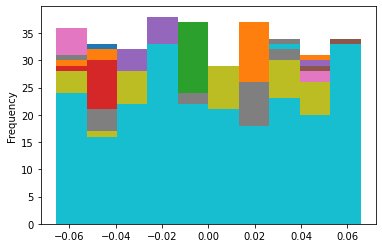

In [108]:
pd.DataFrame(generator.layers[1]._layers[0]._trainable_weights[0].numpy()[:,:50]).plot(kind='hist', legend=None)
plt.show()

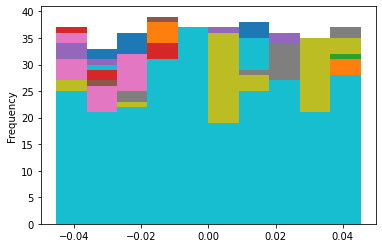

In [109]:
pd.DataFrame(t_gen.seq[1].fc.weight.detach().numpy()[:,:50]).plot(kind='hist', legend=None)
plt.show()

In [30]:
math.sqrt(1/488)

0.045267873021259265

In [165]:
t_gen.seq[0].bn.__dict__

{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [182]:
generator.layers[1]._layers[1].__dict__

{'_self_setattr_tracking': True,
 '_stateful': False,
 '_input_spec': InputSpec(ndim=2, axes={1: 256}),
 '_supports_ragged_inputs': False,
 '_name': 'batch_normalization_6',
 '_activity_regularizer': None,
 '_trainable_weights': [<tf.Variable 'new_residual_layer_5/batch_normalization_6/gamma:0' shape=(256,) dtype=float32, numpy=
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [113]:
t_critic.seq

Sequential(
  (0): Linear(in_features=2610, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

In [110]:
torch.max(t_critic.seq[0].weight)

tensor(0.0196, grad_fn=<MaxBackward1>)

In [112]:
torch.min(t_critic.seq[0].weight)

tensor(-0.0196, grad_fn=<MinBackward1>)

In [114]:
math.sqrt(1/2610)

0.019574007317156784

In [115]:
torch.max(t_critic.seq[0].bias)

tensor(0.0196, grad_fn=<MaxBackward1>)

In [116]:
torch.min(t_critic.seq[0].bias)

tensor(-0.0195, grad_fn=<MinBackward1>)

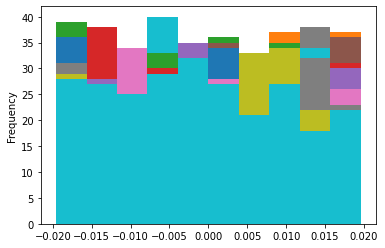

In [117]:
pd.DataFrame(t_critic.seq[0].weight.detach().numpy()[:,:50]).plot(kind='hist', legend=None)
plt.show()

In [434]:
xt = torch.rand(5,4)
xt

tensor([[0.0168, 0.7411, 0.8649, 0.2089],
        [0.3985, 0.8523, 0.5630, 0.0264],
        [0.4863, 0.2912, 0.5228, 0.1410],
        [0.1471, 0.3321, 0.6289, 0.5678],
        [0.4317, 0.9801, 0.3067, 0.6081]])

In [436]:
torch.nn.Dropout(p=0.5)(xt)

tensor([[0.0337, 1.4822, 1.7299, 0.0000],
        [0.7969, 1.7047, 0.0000, 0.0528],
        [0.9726, 0.0000, 1.0456, 0.2819],
        [0.2943, 0.0000, 0.0000, 0.0000],
        [0.8634, 0.0000, 0.6134, 0.0000]])

In [158]:
xtf = tf.random.normal([5,4])
xtf

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-1.1958234 , -1.4560871 , -0.41890395, -1.0489058 ],
       [ 0.27528596,  0.87325877, -0.2334015 ,  0.6482065 ],
       [-0.23452438, -0.13137029, -0.4053114 , -0.38362718],
       [ 0.40711337, -2.1548784 ,  0.1222946 , -0.01449873],
       [-0.5386398 ,  0.7937847 ,  0.05412082,  0.21464786]],
      dtype=float32)>

In [159]:
tf.keras.layers.Dropout(0.9)(xtf, training=True)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-11.958235,  -0.      ,  -0.      ,  -0.      ],
       [  0.      ,   0.      ,  -0.      ,   0.      ],
       [ -0.      ,  -0.      ,  -0.      ,  -0.      ],
       [  0.      ,  -0.      ,   0.      ,  -0.      ],
       [ -0.      ,   0.      ,   0.      ,   0.      ]], dtype=float32)>

In [445]:
tf.keras.layers.LeakyReLU(0.2)(xtf)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 0.9433578 , -0.08978972,  0.20782697,  0.6110454 ],
       [ 0.46428916,  0.54100996,  1.1928254 , -0.12207705],
       [-0.3762341 , -0.04433125, -0.11461028,  0.18351378],
       [ 1.8519161 , -0.29052043, -0.19307765, -0.00823851],
       [ 0.46919137,  0.677982  ,  1.1223804 , -0.3471357 ]],
      dtype=float32)>